In [1]:
import numpy as np
import matplotlib.pyplot as plt
# import spekpy as sp
import os
import pandas as pd
# from datetime import date, time, datetime
from scipy.interpolate import interp1d
import time
# import datetime
from nptdms import TdmsFile
from uncertainties import unumpy as unp
from uncertainties import ufloat

from numpy import array, unique, log
from scipy.optimize import curve_fit
from uncertainties.unumpy import nominal_values, std_devs
# from matplotlib.dates import date2num
# from copy import deepcopy
from os.path import join as pathjoin

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
# import spekpy as sp
import os
import pandas as pd
# from datetime import date, time, datetime
from scipy.interpolate import interp1d
import time
# import datetime
from nptdms import TdmsFile
from uncertainties import unumpy as unp
from uncertainties import ufloat

from numpy import array, unique, log
from scipy.optimize import curve_fit
from uncertainties.unumpy import nominal_values, std_devs
# from matplotlib.dates import date2num
# from copy import deepcopy
from os.path import join as pathjoin

import warnings
warnings.filterwarnings("error")

In [2]:
def nom(arr):
    return nominal_values(arr)

def err(arr):
    return std_devs(arr)

In [3]:
def TicTocGenerator():
    # Generator that returns time differences
    ti = 0           # initial time
    tf = time.time() # final time
    while True:
        ti = tf
        tf = time.time()
        yield tf-ti # returns the time difference

TicToc = TicTocGenerator() # create an instance of the TicTocGen generator

# This will be the main function through which we define both tic() and toc()
def toc(tempBool=True):
    # Prints the time difference yielded by generator instance TicToc
    tempTimeInterval = next(TicToc)
    if tempBool:
        print( "Elapsed time: %f seconds.\n" %tempTimeInterval )

def tic():
    # Records a time in TicToc, marks the beginning of a time interval
    toc(False)

def powerlaw(x,n,ic):
    return (x/ic)**n

def extendedpowerlaw(i,n,ic, R, V0):
    return (i/ic)**n + i*R + V0

In [4]:
plt.rcParams.update({'font.size': 14})

In [5]:
def solvefit(fold_name = "", dataset = "Xray"):
    tdms_file = TdmsFile.read(fold_name + "\\Experiment_DataFile.tdms")
    measured_data = tdms_file['Measured Data'].as_dataframe()
    # aggregated_data = tdms_file['Aggregated Data'].as_dataframe()
    # temperature_data = tdms_file['Temperature Data'].as_dataframe()
    measured_data['Current (A)'] = measured_data['Current (A)'].astype(float)
    measured_data['Voltage (uV/cm)'] = measured_data['Voltage (uV/cm)'].astype(float)
    if '-' in array(measured_data['Temperature (K)']):
        measured_data['Temperature (K)'] = np.nan
    else:
        measured_data['Temperature (K)'] = measured_data['Temperature (K)'].astype(float)
    measured_data['DateTime'] = pd.to_datetime(measured_data['Date'] + ' ' + measured_data['Time'])

    rnum_df = measured_data.groupby("Run Number")
    ic_df = pd.DataFrame(columns=['rnum', 'modeltype', 'n', 'ic', 'R', 'V0', 'DateTime', 'n_err', 'ic_err', 'R_err', 'V0_err', 'temp'])
    for name, df in rnum_df:
        dstmp =  [np.max(df['DateTime'])]
        init_param_dict = {"Xray": [18.5,19.5], "Copper": [28,30], "prior tests": [18.5, 19.5]}
        init_param = init_param_dict[dataset]
        run_temp = df['Temperature (K)'].mean()

        try:
            popt, pcov = curve_fit(powerlaw, df['Current (A)'], df['Voltage (uV/cm)'], p0 = init_param)
            perr = np.sqrt(np.diag(pcov))
        except TypeError:
            popt = np.zeros(2)*float("NaN")
            perr = np.zeros(2)*float("NaN")

        if np.inf in perr:
            popt = np.zeros(2)*float("NaN")
            perr = np.zeros(2)*float("NaN")
        newrow = pd.DataFrame({'rnum' : [name], 'modeltype' : ['power'], 'n' : [popt[0]], 'ic' : [popt[1]], "DateTime" : dstmp, 'n_err' : [perr[0]], 'ic_err' : [perr[1]], 'temp' : run_temp})
        try:
            param_bounds = ([-np.inf, - np.inf, 0, -np.inf],[np.inf, np.inf, np.inf, np.inf])
            popt, pcov = curve_fit(extendedpowerlaw, df['Current (A)'], df['Voltage (uV/cm)'], p0 = np.concat((init_param,[0,0])), bounds = param_bounds)
            perr = np.sqrt(np.diag(pcov))
        except TypeError:
            popt = np.zeros(4)*float("NaN")
            perr = np.zeros(4)*float("NaN")

        if np.inf in perr:
            popt = np.zeros(4)*float("NaN")
        
        newrow1 = pd.DataFrame({'rnum' : [name], 'modeltype' : ['extended'], 'n' : [popt[0]], 'ic' : [popt[1]], 'R' : [popt[2]], 'V0' : [popt[3]], "DateTime" : dstmp, 'n_err' : [perr[0]], 'ic_err' : [perr[1]], 'R_err' : [perr[2]], 'V0_err' : [perr[3]], 'temp' : run_temp})
        ic_df = pd.concat([ic_df, newrow, newrow1], ignore_index=True)
    
    
    ic_df['DateTime'] = ic_df['DateTime'] - np.min(ic_df['DateTime'])
    ic_df['DateTime'] = [ic_df["DateTime"][i].total_seconds() / 3600 for i in range(len(ic_df["DateTime"]))]
    ic_df = ic_df.sort_values(by=['DateTime'])
    ic_df['dataset'] = dataset
    return ic_df


In [6]:
def store_calculated_ic(folders = [], dataset = "Xray", targetnames = [], reset = False):
            
    if len(folders) != len(targetnames):
        return "Folders and Targetnames must have the same length"
    
    try:
        master_df = pd.read_csv("IcData.csv")
    except FileNotFoundError:
        master_df = pd.DataFrame() 

    if reset:
        master_df = pd.DataFrame()

    for (foldname, tname) in zip(folders, targetnames):
        ic_df = solvefit(fold_name= foldname, dataset = dataset)
        ic_df['day'] = tname

        master_df = pd.concat([master_df,ic_df])
    master_df = master_df.drop_duplicates(subset=['rnum', 'modeltype', 'DateTime', 'dataset', 'day'])


    master_df.to_csv('IcData.csv', index = "False")
    return master_df

In [ ]:
folderpath = r"DataFiles\Xray runs"
folders = array([r"\xray_FIRSTRUN", r"\xray_secondrun_1902", r"\xray_thirdrun_morning_2102"])
folders = folderpath + folders

# store_calculated_ic(folders = folders, targetnames = [1,2,3], dataset="Xray", reset = True)

folderpath = r"DataFiles\Copper Tests"
folders = array([r"\Thursday_mixingtesting_01_voltmeter_alreadyON", r"\Friday_mixingtest_voltmeter_justturnedon", r"\Monday_mixingtest_voltmeterONallweekend", r"\Tuesday_bothmeters_onovernight", r"\wednesday_mixingtest_bothmetersjustturnedon"])
folders = folderpath + folders

# mdf = store_calculated_ic(folders = folders, targetnames = [1,2,3,4,5], dataset="Copper")

# rnum_df = icplot()

C:\Users\rohan\AppData\Local\Temp\ipykernel_10476\970348032.py:45: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  ic_df = pd.concat([ic_df, newrow, newrow1], ignore_index=True)
C:\Users\rohan\AppData\Local\Temp\ipykernel_10476\970348032.py:35: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(extendedpowerlaw, df['Current (A)'], df['Voltage (uV/cm)'], p0 = np.concat((init_param,[0,0])), bounds = param_bounds)
C:\Users\rohan\AppData\Local\Temp\ipykernel_10476\970348032.py:45: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old b

test


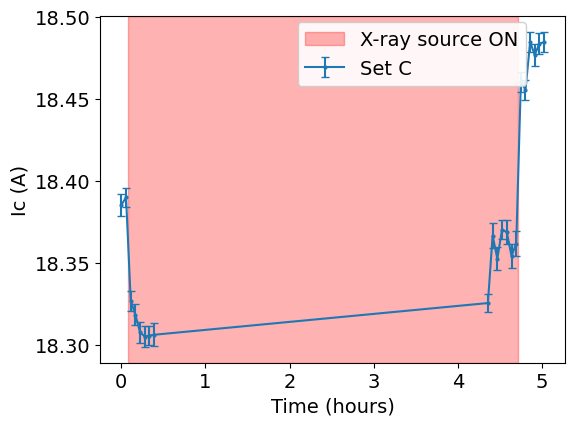

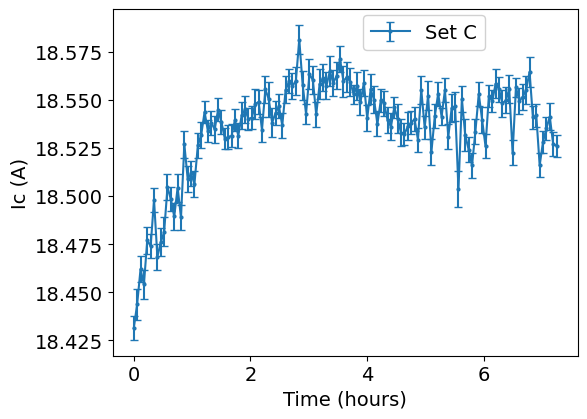

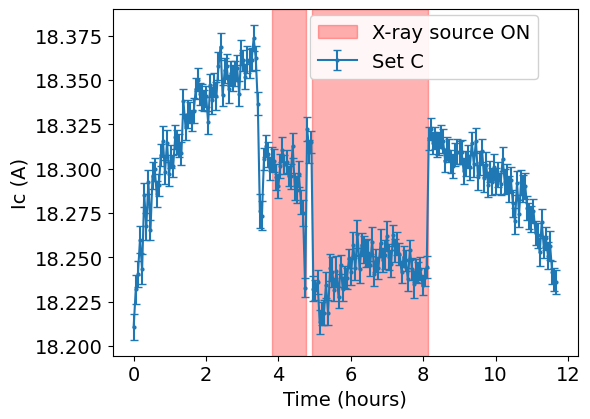

In [35]:
print("test")

def icplot(filters = ["dataset", "day"], imagename = "test.png"):
    crit_times_dict = {'1': [(0.08333333333333333, 4.716666666666667)], '2':[],'3': [(3.816666666666667, 4.766666666666667), (4.916666666666667, 8.133333333333333)]}

    folderpath = r"C:\Users\rohan\OneDrive - Victoria University of Wellington - STAFF\Documents\Latex Documents\Paper\paper_images"
    master_df = pd.read_csv("IcData.csv")
    master_df = master_df[master_df['dataset'] == 'Xray']
    master_df = master_df[master_df['modeltype'] == 'power']
    # master_df = master_df[master_df['day'] == 2]
    master_df = master_df.groupby(filters)

    for (dset_name, dset_day), df in master_df:
        rat = 1.5
        # plt.figure(figsize = (16,5))
        plt.figure(figsize=(4*rat, 3*rat))
        rnum_df = df.groupby("modeltype")
        for modelname, group in rnum_df:
            times = group["DateTime"]
            ic = group["ic"]
            ic_err = group["ic_err"]
            plt.errorbar(times, ic,yerr = ic_err,fmt = 'o-',markersize = 2,capsize=3,label = 'Set C')
        crit_times = crit_times_dict[str(dset_day)]
        alpha = .3
        for pair in crit_times:
            if (pair == crit_times[0]) and len(crit_times)>1:
                label = None
            else:
                label = 'X-ray source ON'
            beg,end = pair
            plt.axvspan(beg, end, alpha=alpha, color='red', label = label)
        plt.legend(loc = 'upper center',bbox_to_anchor=(0.67, 1.01)).get_frame().set_alpha(.9)
        # plt.title(f"Dataset = {dset_name}, Day = {dset_day}")
        # plt.gcf().autofmt_xdate()
        plt.xlabel("Time (hours)")
        plt.ylabel("Ic (A)")
        # plt.savefig(pathjoin(folderpath, imagename + "_" + f"{dset_day}" + "SET"), dpi = 1200,bbox_inches='tight')
    return

rnum_df = icplot(imagename = "results_day")

# Results Section Tables

In [36]:
def relrange(arr):
    return np.ptp(arr)/np.max(arr)

relrange([4,10])

np.float64(0.6)

In [37]:
mdf = pd.read_csv("IcData.csv")
mdf = mdf.dropna(subset = 'ic')
mdf = mdf[mdf['modeltype'] == 'power']
mdf = mdf[mdf['dataset'] == 'Xray']
mdf2 = mdf.groupby(by = ['day', 'modeltype'])[['ic']].agg(['max', np.ptp, relrange])
mdf2

ic                    
                     max       ptp  relrange
day modeltype                               
1   power      18.484595  0.179402  0.009705
2   power      18.581558  0.150194  0.008083
3   power      18.373730  0.163021  0.008873

In [38]:

print(mdf2[('ic', 'relrange')].mean()* 1e2) # percentage

# print()


0.8886987738848063


In [39]:
mdf.groupby(by = ['day', 'modeltype'])[['ic_err']].agg(['mean']).mean()

ic_err  mean    0.006698
dtype: float64

In [40]:
arr = array([0.0634,0.1001,0.0828,0.0733])
maxarr = array([18.484595, 18.484595, 18.373730, 18.373730])
arr/maxarr * 1e2

array([0.34298831, 0.54153202, 0.45064339, 0.39893914])

In [41]:
(tempchanges := array([0.076,0.088,0.073,0.064]))
np.mean(tempchanges)


np.float64(0.07525)

## Temperature Plots

In [42]:
def temp_ic_interpolate(temp_arr, ic_arr, n = False, kind = 'linear'):

    theva_fname = r"C:\Users\rohan\OneDrive - Victoria University of Wellington - STAFF\Documents\THEVA Pro-Line 2G HTS 0 T Temperature Dependence.csv"
    theva_df = pd.read_csv(theva_fname, header = None, names = ['Temp(K)','a','b','ic'])[['Temp(K)', 'ic']]

    baseline_ic = interp1d(theva_df['Temp(K)'], theva_df['ic'], assume_sorted = False, kind = kind)(temp_arr[0]+273.15)
    scaled_ic_arr = ic_arr * (baseline_ic/ic_arr[0])

    corrected_temp = interp1d(theva_df['ic'], theva_df['Temp(K)'], assume_sorted = False, kind = kind)(scaled_ic_arr)
    if n == True:
        return corrected_temp - 273.15 - temp_arr[0]
    else:
        return corrected_temp - 273.15
    
temp_arr = array([-200.4,-200.5,-200.6])
ic_arr = array([18.4,18.5,18.6])
temp_ic_interpolate(temp_arr, ic_arr, n = True)

array([ 0.        , -0.08707808, -0.17415617])

[0.08623508 0.05516298 0.0359179  0.02540804 0.01688093]
[0.04212531 0.03874755 0.03379927 0.03078374 0.02992694]
[0.07935815 0.07339919 0.06467308 0.05353778 0.03727655]


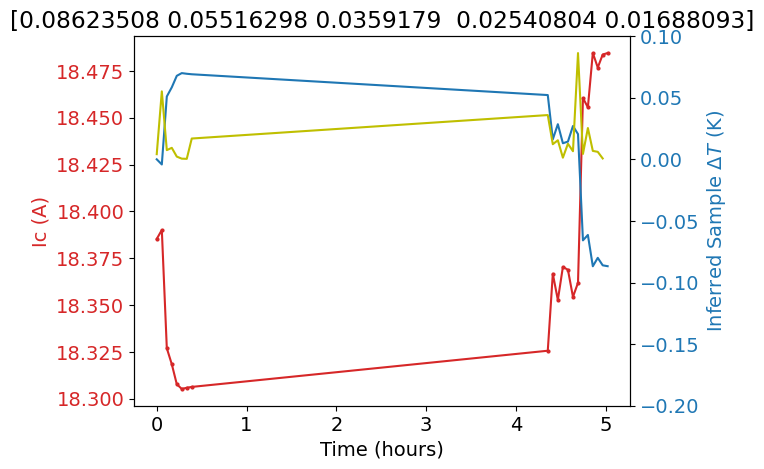

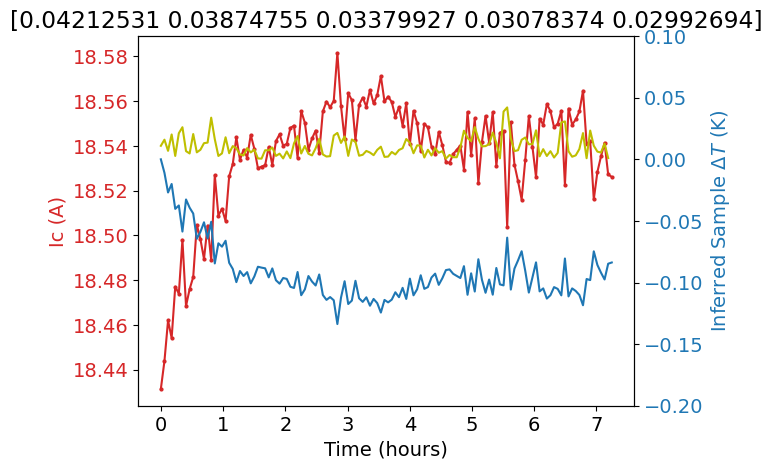

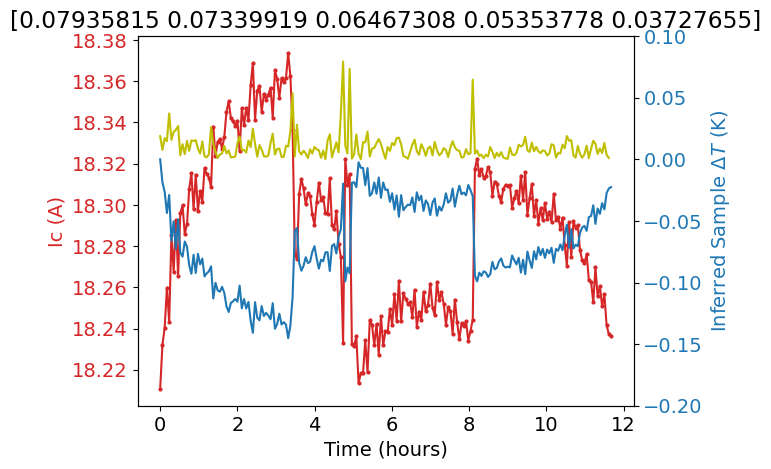

In [43]:
def temp_icplot(filters = ["dataset", "day"], imagename = "test.png"):
    folderpath = r"C:\Users\rohan\OneDrive - Victoria University of Wellington - STAFF\Documents\Latex Documents\Paper\paper_images"
    master_df = pd.read_csv("IcData.csv")
    master_df = master_df[master_df['dataset'] == 'Xray']
    master_df = master_df[master_df['modeltype'] == 'power']
    master_df = master_df.groupby(filters)

    for (dset_name, dset_day), df in master_df:
        rat = 1.5
        # plt.figure(figsize = (16,5))
        # plt.figure(figsize=(4*rat, 3*rat))
        fig, ax1 = plt.subplots()
        rnum_df = df.groupby("modeltype")
        for modelname, group in rnum_df:
            times = group["DateTime"]
            ic = array(group["ic"])
            ic_err = group["ic_err"]


            color = 'tab:red'
            ax1.set_xlabel("Time (hours)")
            ax1.set_ylabel("Ic (A)", color=color)
            ax1.errorbar(times, ic,fmt = 'o-',markersize = 2,capsize=3,label = modelname, color=color)
            # ax1.fill_between(times, ic-ic_err, ic+ic_err, step = None, color = color)
            ax1.tick_params(axis='y', labelcolor=color)
            

            ax2 = ax1.twinx()
            color = 'tab:blue'
            temps = array(group['temp'])
            # ax2.plot(times, temps, 'r')
            corrected = array(temp_ic_interpolate(temps, ic, n = True, ), dtype = float)
            ax2.plot(times, corrected, color=color, )
            ax2.tick_params(axis='y', labelcolor=color)
            # ax2.set_yticks([])
            
            ax2.ticklabel_format( useOffset = False)
            ax2.set_ylabel(rf"Inferred Sample $\Delta T$ (K)", color=color)
            ax2.tick_params(axis='y', labelcolor=color)


            diffs = np.ediff1d(corrected)
            ax2.plot(times[:-1], np.abs(diffs), 'y')
            diffs = array(sorted(np.abs(diffs), reverse = True))
            print(diffs[:5])

            plt.title(diffs[:5])
            ax2.set_ylim([-0.2,0.1])

        # fig.gcf().autofmt_xdate()
        # plt.savefig(pathjoin(folderpath, imagename + "_" + f"{dset_day}"), dpi = 300,bbox_inches='tight')
    return

temp_icplot(imagename='results_temp_day')

In [44]:
tempchanges = np.mean([0.08623508, 0.05516298, 0.07339919, 0.06467308])

In [45]:
np.std(tempchanges)/np.sqrt(4)

np.float64(0.0)

In [46]:
plt.rcParams.update({'font.size': 14})

In [47]:
theva_fname = r"C:\Users\rohan\OneDrive - Victoria University of Wellington - STAFF\Documents\THEVA Pro-Line 2G HTS 0 T Temperature Dependence.csv"
theva_df = pd.read_csv(theva_fname, header = None, names = ['Temp(K)','a','b','ic'])[['Temp(K)', 'ic']]

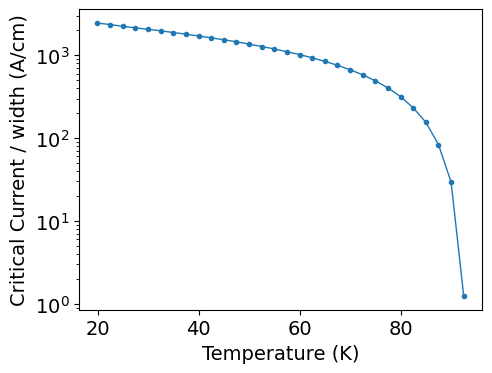

In [48]:
folderpath = r"C:\Users\rohan\OneDrive - Victoria University of Wellington - STAFF\Documents\Latex Documents\Paper\paper_images"
rat = 1.3
plt.figure(figsize = (4*rat,3*rat))
plt.plot(theva_df['Temp(K)'], theva_df['ic'], linewidth=1)
plt.scatter(theva_df['Temp(K)'], theva_df['ic'], s=9)
plt.xlabel("Temperature (K)")
plt.ylabel(rf"Critical Current / width (A/cm)")
plt.yscale('log')
# plt.savefig(pathjoin(folderpath, "theva_data"), dpi = 1200,bbox_inches='tight')

absorbedpower=8.0075664e-07
incidentwattsperarea=0.1668243


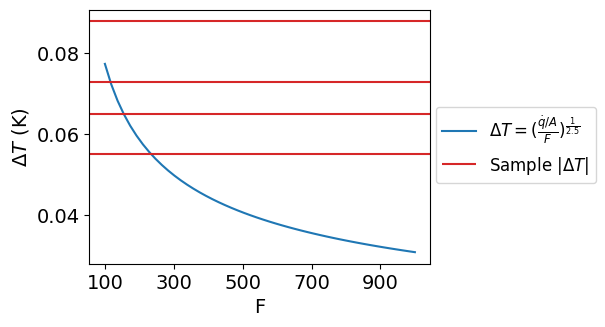

In [49]:
ρ = {"air":1.225e-3, "polystyrene":0.96, "copper":8.96, "hastelloy":3.58, "beryllium": 1.848}

rho_tape = 7.039

A_b = 300e-6*1.6e-2
V_b = A_b * 1e-6
A_t = 12e-3 * 44e-3
V_t = A_t * 80e-6

A = A_b
V = V_b

doseused = 23.7

mass_bridge = V * rho_tape *1e3 # kg
absorbedpower = doseused * mass_bridge #watts
print(f'{absorbedpower=}')
incidentwattsperarea = absorbedpower/A
incidentwattsperarea


factor = np.linspace(100,1000,50)
Tchange = (incidentwattsperarea/factor)**(1/2.5) #K
Tchange500 = (incidentwattsperarea/500)**(1/2.5) #K
print(f"{incidentwattsperarea=}")
ltext = r"$\Delta T = (\frac{\dot{q}/A}{F})^{\frac{1}{2.5}}$"
rat = 1.1
plt.figure(figsize = (4*rat,3*rat))
plt.plot(factor, Tchange, label = ltext)

# plt.title(f"Expected Temperature Change with Dosage Rate = {doseused} Gy/s")
plt.xlabel("F")
plt.ylabel(r"$\Delta T$ (K)")
# plt.yticks(np.arange(0.03,0.09,0.01))
plt.xticks(np.arange(100,1000,200))
xmin, xmax, bottom, top = plt.axis()
plt.xlim([xmin, xmax])
htemps = [0.055, 0.088,0.073,0.065]
plt.hlines(htemps, xmin = xmin, xmax = xmax, label = rf"Sample $|\Delta T|$", colors = 'tab:red')
plt.legend(prop={'size': 12}, loc = 'upper right', bbox_to_anchor=(1.51, .65))
# print(f"Expected Delta T using factor=500 is {Tchange500}K")
plt.savefig(pathjoin(folderpath, "ekin_plot_new"), dpi = 1200,bbox_inches='tight')

### Temperature testing

In [50]:
def change_timedict(times_dict):
    for k,v in times_dict.items():
        for i in range(len(times_dict[k])):
            times_dict[k][i]=pd.Timedelta(times_dict[k][i]).total_seconds()/3600

In [51]:
mixtimes = {'1':['04:45:00', '05:27:00', '05:49:00'],'2':['04:21:00', '05:39:00', '06:57:00'],'3': ['02:04:00'], '4':['03:57:00'],'5': ['02:12:00', '04:02:00']}
filltimes = {'1':['03:13:00'],'2': ['04:16:00'],'3': ['04:20:00'],'4':['04:28:00'], '5': ['04:51:00']}
change_timedict(mixtimes)
change_timedict(filltimes)

def copper_icplot(mixtimes = mixtimes,filters = ["dataset", "day"], imagename = "test.png"):
    folderpath = r"C:\Users\rohan\OneDrive - Victoria University of Wellington - STAFF\Documents\Latex Documents\Paper\paper_images"
    master_df = pd.read_csv("IcData.csv")
    master_df = master_df[master_df['dataset'] == 'Copper']
    master_df = master_df[master_df['modeltype'] == 'extended']
    # master_df = master_df.query('day == 3 or day == 5')

    master_df = master_df.groupby(filters)

    for (dset_name, dset_day), df in master_df:
        rat = 1.5
        plt.figure(figsize = (4,3))
        plt.figure(figsize=(4*rat, 3*rat))
        rnum_df = df.groupby("modeltype")
        for modelname, group in rnum_df:
            times = group["DateTime"]
            ic = group["ic"]
            ic_err = group["ic_err"]
            plt.errorbar(times, ic,fmt = 'o-',markersize = 2,capsize=3,label = 'Data Points', zorder = 1)
            # plt.errorbar(times, ic, yerr = ic_err,fmt = 'o-',markersize = 2,capsize=3,label = modelname)

        # ic_mean = np.mean(ic)
        # offset = 0.15
        # plt.ylim([ic_mean-offset,ic_mean + offset])
        lwid = 2
        xmin, xmax, bottom, top = plt.axis()
        plt.ylim([bottom,top])
        if str(dset_day) in mixtimes.keys():
            plt.vlines(mixtimes[str(dset_day)], ymin = bottom, ymax = top, label = 'MIXED', color = 'tab:red', zorder = 0, linewidth = lwid)

        if str(dset_day) in filltimes.keys():
            plt.vlines(filltimes[str(dset_day)], ymin = bottom, ymax = top, label = 'REFILLED', color = 'tab:green', linewidth = lwid,zorder = 0)

        plt.legend(loc = 'lower left').get_frame().set_alpha(1)
        # plt.title(f"Dataset = {dset_name}, Day = {dset_day}")
        # plt.gcf().autofmt_xdate()
        plt.xlabel("Time (hours)")
        plt.ylabel("Ic (A)")



        # plt.savefig(pathjoin(folderpath, imagename + "_" + f"{dset_day}"), dpi = 1200,bbox_inches='tight')
    return

copper_icplot(imagename='copperplots_day')

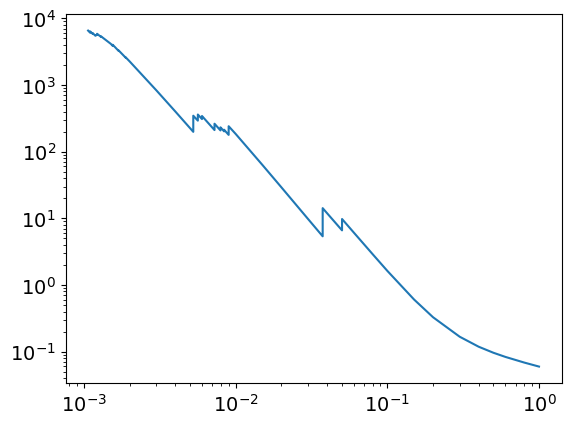

In [52]:
fname = r"C:\Users\rohan\Downloads\data.pl.txt"
df = pd.read_csv(fname, delimiter = ' ', header = 3, names = ['energy', 'coff', 'inds'])
en = df.energy
coffs = df.coff
plt.loglog(en,coffs)


Text(0, 0.5, 'Critical Current (A)')

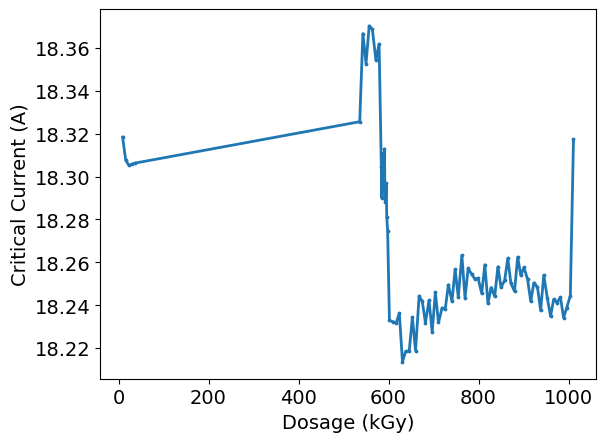

In [53]:
fname = r"C:\Users\rohan\Downloads\icdos.txt"
df = pd.read_csv(fname, delimiter = '\t', names = ['dosage', 'ic',' '], header = 1)
plt.scatter(df.dosage, df.ic, s = 3)
plt.plot(df.dosage, df.ic, linewidth = 2)
plt.xlabel('Dosage (kGy)')
plt.ylabel('Critical Current (A)')

In [1]:
def dosage_icplot(mixtimes = mixtimes,filters = ["dataset", "day"], imagename = "test.png"):
    folderpath = r"C:\Users\rohan\OneDrive - Victoria University of Wellington - STAFF\Documents\Latex Documents\Paper\paper_images"
    master_df = pd.read_csv("IcData.csv")
    master_df = master_df[master_df['dataset'] == 'Xray']
    master_df = master_df[master_df['modeltype'] == 'power']
    master_df = master_df.query('day == 1 or day == 3')

    master_df = master_df.groupby(filters)

    fig,ax1 = plt.subplots()
    ic_err_dict = {}
    stime = 0.
    colours = ['tab:blue', 'tab:green']
    i = 0
    dayname = ['A','B']
    for (dset_name, dset_day), group in master_df:
        color = colours[i]
        times = array(group["DateTime"])+stime

        ic = group["ic"]
        ic_err = group["ic_err"]
        plt.errorbar(times, ic,yerr = ic_err,fmt = 'o-',markersize = 2,capsize=3,label = "Set " + str(dayname[i]), color = color, zorder = 5)
        stime = times[-1]
        i+=1
        


    fname = r"C:\Users\rohan\Downloads\icdosall.txt"
    df = pd.read_csv(fname, delimiter = '\t')
    
    for i in np.arange(0,10,2):
        tcol = df.iloc[:,[i]]
        oldlen = len(tcol)
        tcol = np.hstack(array(tcol))# + ':00'
        tcol = array([x for x in tcol if x == x])
        tcol = tcol + ":00"
        newtcol = pd.to_timedelta(tcol)
        newtcol = newtcol.total_seconds()/3600
        newlen = len(newtcol)
        nanarr = np.zeros((oldlen-newlen,)) * float('nan')
        df.iloc[:,[i]] = np.concat([newtcol, nanarr])
    crit_times = array(df.iloc[:,[6]])
    crit_times = np.hstack(array([x for x in crit_times if x == x]))
    # print(crit_times)
    labels = ['Day 1', 'Day 3']
    daynum = ['1','3']
    alpha = 0.3

    # for beg,end in zip(crit_times[0:4:2],crit_times[1:4:2]):
    #     ax1.axvspan(beg, end, alpha=alpha, color='red')
    # ax1.axvspan(crit_times[-2], crit_times[-1], alpha=alpha, color='red', )


    # for li,i in enumerate(np.arange(0,4,2)):
    #     print(len(df.iloc[:,[i+1]]), len(ic_err_dict[daynum[li]]))
    #     ax1.errorbar(x=df.iloc[:,[i]], y=df.iloc[:,[i+1]], label = labels[li])


    ax1.set_xlabel('Time (hours)')
    ax1.set_ylabel('Critical Current (A)')
    xmin, xmax, ymin, ymax = ax1.axis()
    ax2 = ax1.twinx()

    zorder = 0
    beg,end = crit_times[:2]
    ax2.axvspan(beg, end, alpha=alpha, color='red', label = 'X-ray ON (23.7 Gy/s)', zorder = zorder)
    beg,end = crit_times[2:4]
    ax2.axvspan(beg, end, alpha=alpha, color='tab:orange', label = 'Seasoning', zorder = zorder)
    beg,end = crit_times[4:6]
    ax2.axvspan(beg, end, alpha=alpha, color='red', zorder = zorder)

    color = 'tab:red'
    ax2.plot(df.iloc[:,[4]], df.iloc[:,[5]], label = 'Cumulative Dosage', color =color)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_ylabel('Dosage (kGy)', color=color)

    xmin, xmax, ymin, ymax = ax2.axis()



    ax2.legend(loc='upper right', bbox_to_anchor=(1, 1.3)).get_frame().set_alpha(1)

    ax1.legend(loc='upper left', bbox_to_anchor=(0, 1.22)).get_frame().set_alpha(1)



    # plt.savefig(pathjoin(folderpath, imagename + "_" + f"{dset_day}"), dpi = 1200,bbox_inches='tight')

    # for item in ([ax1.title, ax1.xaxis.label, ax1.yaxis.label] +
    #          ax1.get_xticklabels() + ax1.get_yticklabels()):
    #     item.set_fontsize(20)
    # print(df.iloc[:,[5]].dropna())
    return
colseqA = ['tab:purple', 'tab:cyan']
basetime = 5.030342444444445
ann = [(basetime + 3.14389,18.36153), (basetime + 5.138333,18.21346)]
ann_loc = [(7.5,18.4), (8,18.225)]
dosage_icplot(imagename='plot_day1_3_withdos')
fig = plt.gcf()
(ax1,ax2) = fig.axes

ax3 = ax1.twinx()
ax3.axis(ax1.axis())
ax3.set_axis_off()
for i in range(len(ann)):
    ax3.annotate(f'$t_{i}$', xy =ann[i],
                    xytext =ann_loc[i], 
                    arrowprops = dict(arrowstyle = "->", linewidth = 2, color = colseqA[i]),
                    zorder = ax2.get_zorder()+1, 
                    color = colseqA[i], fontsize = 16)
ax3.patch.set_visible(False)

plt.savefig(pathjoin(folderpath, "plot_day1_3_withdos_3_ANNOTATED"), dpi = 1200,bbox_inches='tight')

NameError: name 'mixtimes' is not defined

In [55]:
def readlabviewdosfiles():
    fname = r"C:\Users\rohan\Downloads\icdosall.txt"
    df = pd.read_csv(fname, delimiter = '\t')
    # df = df.convert_dtypes()
    for i in np.arange(0,10,2):
        tcol = df.iloc[:,[i]]
        oldlen = len(tcol)
        tcol = np.hstack(array(tcol))# + ':00'
        tcol = array([x for x in tcol if x == x])
        tcol = tcol + ":00"
        newtcol = pd.to_timedelta(tcol)
        newtcol = newtcol.total_seconds()/3600
        newlen = len(newtcol)
        nanarr = np.zeros((oldlen-newlen,)) * float('nan')
        df.iloc[:,[i]] = np.concat([newtcol, nanarr])
    crit_times = array(df.iloc[:,[6]])
    crit_times = np.hstack(array([x for x in crit_times if x == x], dtype = float))

    return df, crit_times


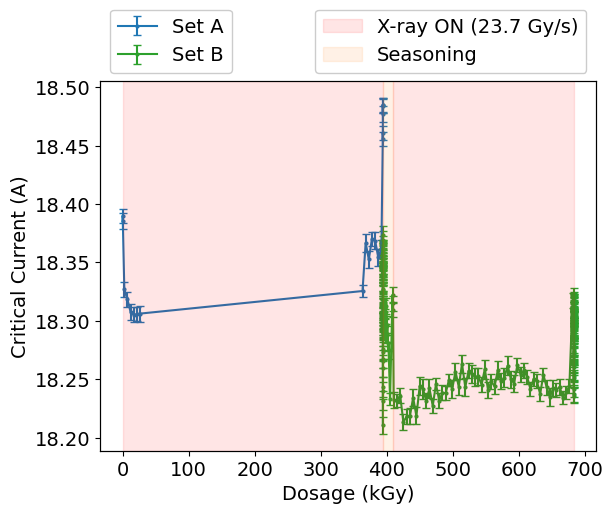

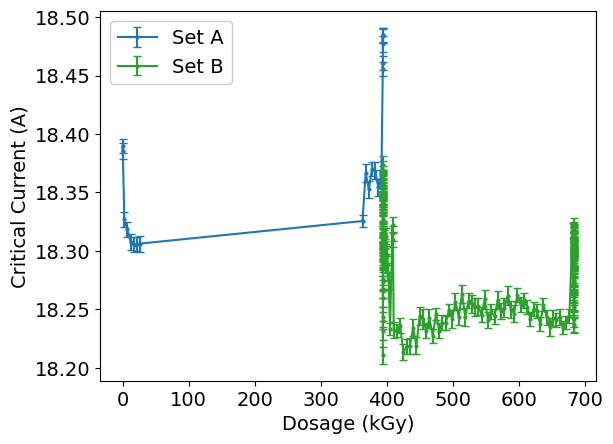

In [131]:
def icvsdosage_plot(mixtimes = mixtimes,filters = ["dataset", "day"], imagename = "test.png",  bartoplot = 0):
    folderpath = r"C:\Users\rohan\OneDrive - Victoria University of Wellington - STAFF\Documents\Latex Documents\Paper\paper_images"
    master_df = pd.read_csv("IcData.csv")
    master_df = master_df[master_df['dataset'] == 'Xray']
    master_df = master_df[master_df['modeltype'] == 'power']
    master_df = master_df.query('day == 1 or day == 3')
    master_df = master_df.groupby(filters)

    df,crit_times = readlabviewdosfiles()
    dostime = np.hstack(array(df.iloc[:,[4]].dropna(), dtype = float))
    cumuldose = np.hstack(array(df.iloc[:,[5]].dropna(), dtype = float))
    dose_interp =  interp1d(dostime, cumuldose)

    fig,ax1 = plt.subplots()

    stime = 0.
    colours = ['tab:blue', 'tab:green']

    dayname = ['A','B']
    for i, ((dset_name, dset_day), group) in enumerate(master_df):
        color = colours[i]
        times = array(group["DateTime"])+stime

        ic = group["ic"]
        ic_err = group["ic_err"]
        plt.errorbar(dose_interp(times), ic,yerr = ic_err,fmt = 'o-',markersize = 2,capsize=3,label = "Set " + str(dayname[i]), color = color, zorder = 5)
        stime = times[-1]

    ax1bbox = None


    # Comment out to remove alpha bars
    if bartoplot:
        ax1bbox = (0,1.22)
        ax2 = ax1.twinx()
        ax2.set_yticks([])
        crit_doses = dose_interp(crit_times)
        zorder = -1
        alpha = 0.1
        beg,end = crit_doses[:2]
        ax2.axvspan(beg, end, alpha=alpha, color='red', label = 'X-ray ON (23.7 Gy/s)', zorder = zorder)
        beg,end = crit_doses[2:4]
        ax2.axvspan(beg, end, alpha=alpha, color='tab:orange', label = 'Seasoning', zorder = zorder)
        beg,end = crit_doses[4:6]
        ax2.axvspan(beg, end, alpha=alpha, color='red', zorder = zorder)
        ax2.legend(loc='upper right', bbox_to_anchor=(1, 1.22)).get_frame().set_alpha(1)  


    ax1.set_xlabel('Dosage (kGy)')
    ax1.set_ylabel('Critical Current (A)')

    ax1.legend(loc='upper left', bbox_to_anchor=ax1bbox).get_frame().set_alpha(1)



    # plt.savefig(pathjoin(folderpath, imagename), dpi = 1200,bbox_inches='tight')



    return

icvsdosage_plot(imagename='ic_vs_dosage_bars', bartoplot = 1)
icvsdosage_plot(imagename='ic_vs_dosage', bartoplot = 0)

In [57]:
plt.rcParams.update({'font.size': 14})

[0.08333333333333333 4.716666666666667 8.883333333333333 9.833333333333334
 9.983333333333333 13.2]


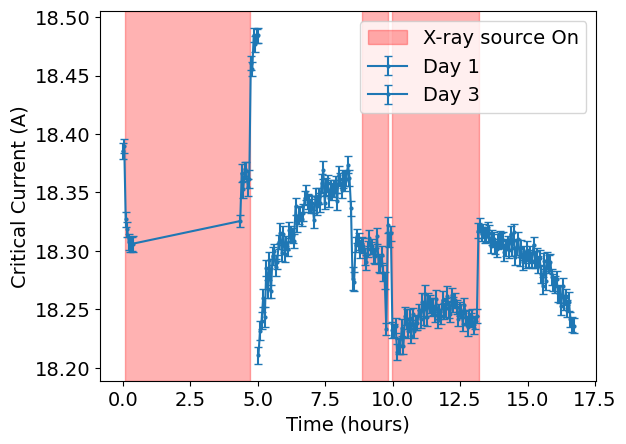

In [58]:
def dosage_icplot(mixtimes = mixtimes,filters = ["dataset", "day"], imagename = "test.png"):
    folderpath = r"C:\Users\rohan\OneDrive - Victoria University of Wellington - STAFF\Documents\Latex Documents\Paper\paper_images"
    master_df = pd.read_csv("IcData.csv")
    master_df = master_df[master_df['dataset'] == 'Xray']
    master_df = master_df[master_df['modeltype'] == 'power']
    master_df = master_df.query('day == 1 or day == 3')

    master_df = master_df.groupby(filters)

    fig,ax1 = plt.subplots()
    ic_err_dict = {}

    colours = ['tab:blue', 'tab:green']
    i = 0
    stime = 0

    for (dset_name, dset_day), group in master_df:
        color = colours[i]
        times = array(group["DateTime"])+stime

        ic = group["ic"]
        ic_err = group["ic_err"]
        plt.errorbar(times, ic,yerr = ic_err,fmt = 'o-',markersize = 2,capsize=3,label = "Day " + str(dset_day), color = color)
        stime = times[-1]

        


    fname = r"C:\Users\rohan\Downloads\icdosall.txt"
    df = pd.read_csv(fname, delimiter = '\t')

    for i in np.arange(0,10,2):
        tcol = df.iloc[:,[i]]
        oldlen = len(tcol)
        tcol = np.hstack(array(tcol))# + ':00'
        tcol = array([x for x in tcol if x == x])
        tcol = tcol + ":00"
        newtcol = pd.to_timedelta(tcol)
        newtcol = newtcol.total_seconds()/3600
        newlen = len(newtcol)
        nanarr = np.zeros((oldlen-newlen,)) * float('nan')
        df.iloc[:,[i]] = np.concat([newtcol, nanarr])
    crit_times = array(df.iloc[:,[6]])
    crit_times = np.hstack(array([x for x in crit_times if x == x]))
    print(crit_times)
    labels = ['Day 1', 'Day 3']
    daynum = ['1','3']
    alpha = 0.3
    for beg,end in zip(crit_times[0:4:2],crit_times[1:4:2]):
        ax1.axvspan(beg, end, alpha=alpha, color='red')
    ax1.axvspan(crit_times[-2], crit_times[-1], alpha=alpha, color='red', label = 'X-ray source On')
    
    ax1.legend(loc='upper right')
    ax1.set_xlabel('Time (hours)')
    ax1.set_ylabel('Critical Current (A)')
    # folderpath = r"C:\Users\rohan\OneDrive - Victoria University of Wellington - STAFF\Documents\Latex Documents\Paper\paper_images"
    # plt.savefig(pathjoin(folderpath, imagename + "_" + f"{dset_day}"), dpi = 1200,bbox_inches='tight')
    return

dosage_icplot(imagename='copperplots_day')

In [59]:
def get_crit_times(fname):
    df = pd.read_csv(fname, delimiter = '\t')

    for i in np.arange(0,7,2):
        tcol = df.iloc[:,[i]]
        oldlen = len(tcol)
        tcol = np.hstack(array(tcol))# + ':00'
        tcol = array([x for x in tcol if x == x])
        tcol = tcol + ":00"
        newtcol = pd.to_timedelta(tcol)
        newtcol = newtcol.total_seconds()/3600
        newlen = len(newtcol)
        nanarr = np.zeros((oldlen-newlen,)) * float('nan')
        df.iloc[:,[i]] = np.concat([newtcol, nanarr])
    crit_times = array(df.iloc[:,[6]])
    crit_times = np.hstack(array([x for x in crit_times if x == x]))
    print(crit_times)
    return crit_times

fname = r"C:\Users\rohan\Downloads\icdos1.txt"
_ = get_crit_times(fname)

fname = r"C:\Users\rohan\Downloads\icdos3.txt"
_ = get_crit_times(fname)

[0.08333333333333333 4.716666666666667]
[3.816666666666667 4.766666666666667 4.916666666666667 8.133333333333333]


In [60]:
crit_times_dict = {'1': [(0.08333333333333333, 4.716666666666667)], '2': [(3.816666666666667, 4.766666666666667), (4.916666666666667, 8.133333333333333)]}